# Watershed Segmentation

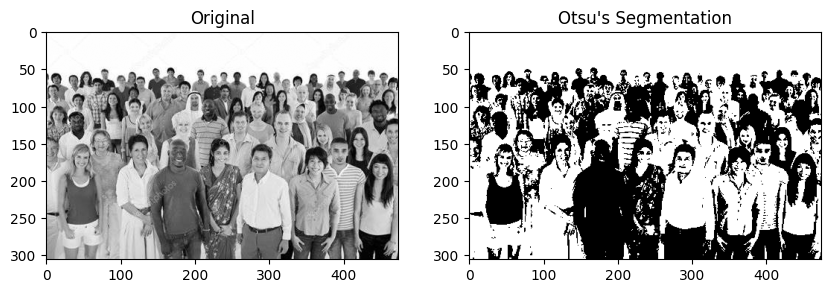

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
img = cv2.imread('/content/drive/MyDrive/faces.jpg', 0)

# Apply Otsu's thresholding
_, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray'), plt.title("Original")
plt.subplot(1, 2, 2), plt.imshow(binary_img, cmap='gray'), plt.title("Otsu's Segmentation")
plt.show()


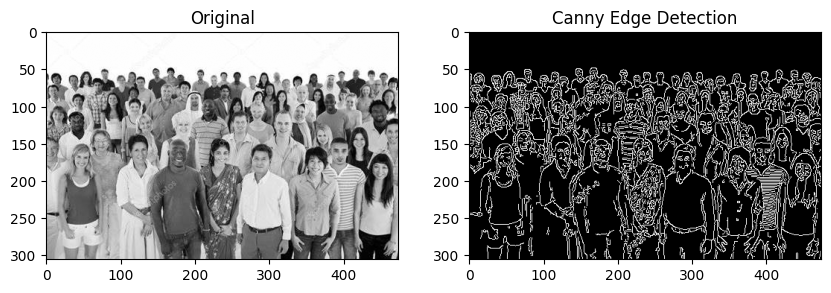

In [ ]:
edges = cv2.Canny(img, 100, 200)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray'), plt.title("Original")
plt.subplot(1, 2, 2), plt.imshow(edges, cmap='gray'), plt.title("Canny Edge Detection")
plt.show()


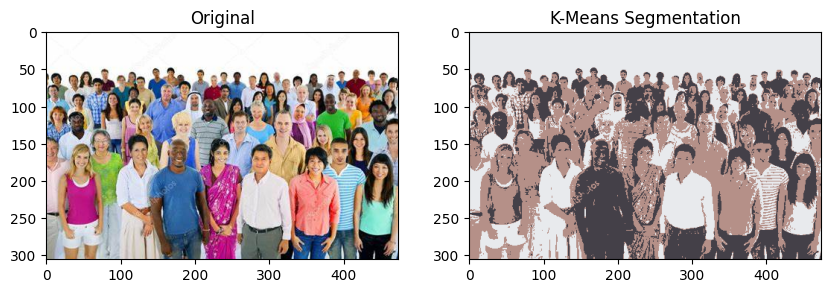

In [ ]:
img = cv2.imread('/content/drive/MyDrive/faces.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pixel_vals = img.reshape((-1, 3)).astype(np.float32)

# Apply K-Means Clustering
k = 3  # Number of segments
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to image
centers = np.uint8(centers)
segmented_img = centers[labels.flatten()].reshape(img.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img), plt.title("Original")
plt.subplot(1, 2, 2), plt.imshow(segmented_img), plt.title("K-Means Segmentation")
plt.show()


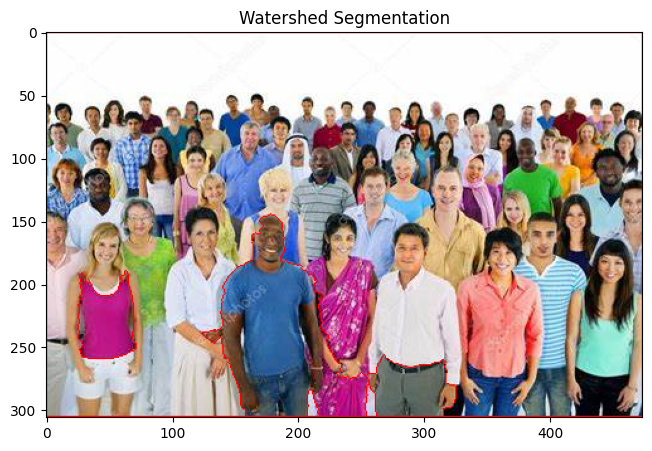

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find sure background and foreground
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=3)
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Marker labelling
unknown = cv2.subtract(np.uint8(sure_bg), np.uint8(sure_fg))

_, markers = cv2.connectedComponents(np.uint8(sure_fg))
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]  # Mark boundaries in red

plt.figure(figsize=(10, 5))
plt.imshow(img), plt.title("Watershed Segmentation")
plt.show()


#Active Contours (Model Based Segmentation)

Active Contours (Snakes) in Image Segmentation
Active Contours, or "Snakes," is an image segmentation technique that **detects object boundaries** by **evolving a curve** based on **internal and external energy forces.**

How Active Contours Work:
    Initialize a contour (curve): A set of points (a closed curve) is placed near the object boundary.

Energy Minimization:
    Internal Energy: Keeps the contour smooth and continuous.
    External Energy: Attracts the contour toward image edges (gradient-based).

Contour Evolution: The contour iteratively moves until it aligns with object boundaries.

Key Parameters:
* alpha (Elasticity): Controls smoothness (higher = stiffer contour).
* beta (Rigidity): Helps resist bending.
* gamma (Time Step): Determines step size in contour evolution.

Advantages of Active Contours:
* ✔ Works well for smooth object boundaries.
* ✔ Can refine segmentation after initial detection.
* ✔ More robust than simple thresholding or edge detection.

Limitations:

*   ❌ Requires a good initialization.
*   ❌ Sensitive to weak edges and noise.
*   ❌ Slow for large images.




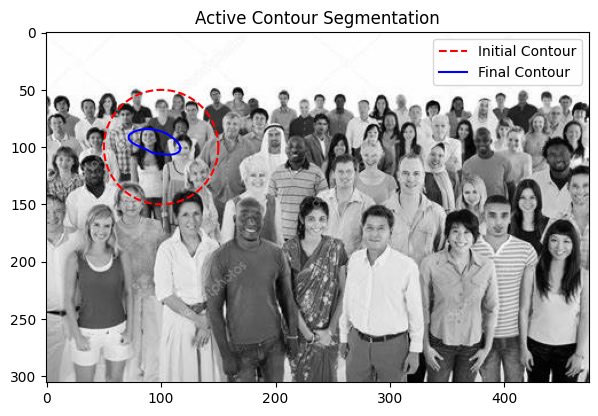

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Load and preprocess the image
img = cv2.imread('/content/drive/MyDrive/faces.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian smoothing
img_smooth = gaussian(img_gray, sigma=3)

# Initialize a circular contour around an object
s = np.linspace(0, 2*np.pi, 100)
x = 100 + 50*np.cos(s)  # Adjust position and radius
y = 100 + 50*np.sin(s)
init_contour = np.array([x, y]).T

# Apply Active Contour Model
snake = active_contour(img_smooth, init_contour, alpha=0.015, beta=10, gamma=0.001)

# Plot the results
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_gray, cmap='gray')
ax.plot(init_contour[:, 0], init_contour[:, 1], '--r', label="Initial Contour")
ax.plot(snake[:, 0], snake[:, 1], '-b', label="Final Contour")
ax.legend()
plt.title("Active Contour Segmentation")
plt.show()


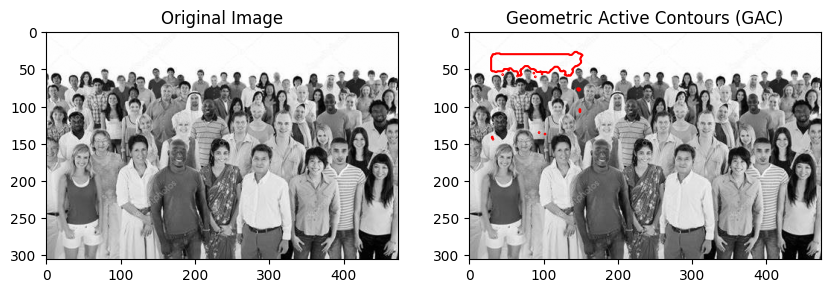

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color, segmentation, filters, morphology

# Load and preprocess the image
img = cv2.imread('/content/drive/MyDrive/faces.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Compute the gradient magnitude (edge indicator function)
edges = filters.sobel(img_gray)

# Initialize level set as a small filled region
init_level_set = np.zeros_like(img_gray)
init_level_set[30:150, 30:150] = 1  # Square region initialization

# Apply Morphological Geodesic Active Contours (GAC)
gac_result = segmentation.morphological_geodesic_active_contour(
    edges, num_iter=200, init_level_set=init_level_set, smoothing=1, balloon=-1
)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray, cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(img_gray, cmap="gray")
ax[1].contour(gac_result, [0.5], colors='r')
ax[1].set_title("Geometric Active Contours (GAC)")
plt.show()


## From scratch

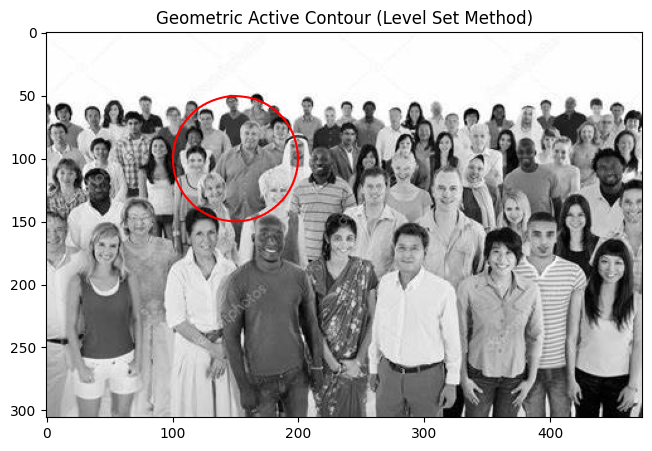

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel

# Load and preprocess the image
img = cv2.imread('/content/drive/MyDrive/faces.jpg', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0  # Normalize image

# Compute Edge-Stopping Function (Gradient Magnitude)
def edge_indicator(img, sigma=1.0):
    img_smooth = gaussian_filter(img, sigma)  # Smooth the image
    grad_x = sobel(img_smooth, axis=0)  # Compute gradients
    grad_y = sobel(img_smooth, axis=1)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)  # Gradient magnitude
    return 1 / (1 + grad_mag)  # Edge stopping function

# Initialize Level Set Function (Signed Distance Function)
def initialize_lsf(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    return np.sqrt((x - center[0])**2 + (y - center[1])**2) - radius

# Compute Curvature
def compute_curvature(phi):
    phi_x = sobel(phi, axis=1)
    phi_y = sobel(phi, axis=0)
    norm = np.sqrt(phi_x**2 + phi_y**2) + 1e-10
    phi_x /= norm
    phi_y /= norm
    div = np.gradient(phi_x, axis=1) + np.gradient(phi_y, axis=0)
    return div

# Level Set Evolution (Geometric Active Contour)
def level_set_evolution(img, phi, edge_func, num_iter=200, dt=0.1):
    for _ in range(num_iter):
        curvature = compute_curvature(phi)
        force = edge_func * curvature  # Edge-stopping function
        phi += dt * force  # Update level set
        phi = np.clip(phi, -3, 3)  # Keep level set within bounds
    return phi

# Initialize LSF
phi = initialize_lsf(img.shape, center=(150, 100), radius=50)

# Compute Edge-Stopping Function
edge_func = edge_indicator(img)

# Apply Level Set Evolution
phi = level_set_evolution(img, phi, edge_func)

# Plot Results
plt.figure(figsize=(10, 5))
plt.imshow(img, cmap='gray')
plt.contour(phi, [0], colors='r')  # Plot level set contour
plt.title("Geometric Active Contour (Level Set Method)")
plt.show()


#Chan Vese(Active contour)

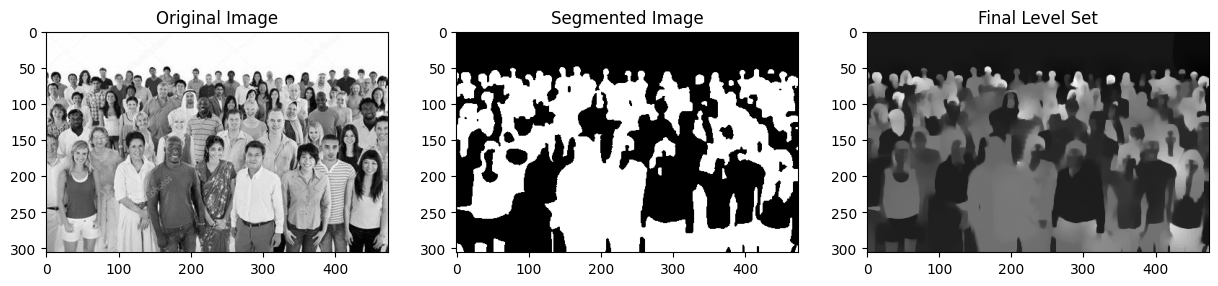

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import chan_vese

# Load image
image = cv2.imread('/content/drive/MyDrive/faces.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
gray = gray / 255.0  # Normalize to [0,1]

# Apply Chan-Vese segmentation
cv_result = chan_vese(gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, extended_output=True)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray, cmap="gray")
axes[0].set_title("Original Image")

axes[1].imshow(cv_result[0], cmap="gray")
axes[1].set_title("Segmented Image")

axes[2].imshow(cv_result[1], cmap="gray")
axes[2].set_title("Final Level Set")

plt.show()


From scratch

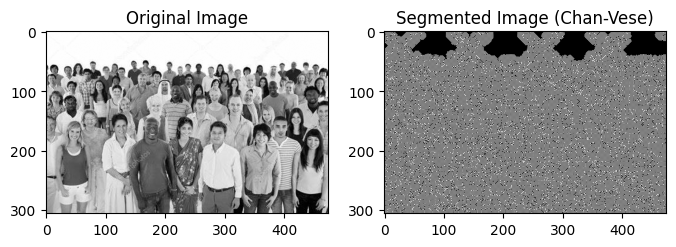

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def chan_vese_manual(image, iterations=100, dt=0.1, mu=0.25):
    h, w = image.shape
    phi = np.ones((h, w))  # Initialize level set function
    phi[h//4:3*h//4, w//4:3*w//4] = -1  # Initialize as a square

    for _ in range(iterations):
        inside = image[phi <= 0]  # Inside region
        outside = image[phi > 0]  # Outside region
        c1, c2 = inside.mean(), outside.mean()  # Compute mean intensities

        force = (image - c1)**2 - (image - c2)**2  # Compute force term
        phi += dt * (force - mu * cv2.Laplacian(phi, cv2.CV_64F))  # Update level set

    return phi < 0  # Final segmentation

# Load grayscale image
image = cv2.imread('coins.jpg', cv2.IMREAD_GRAYSCALE) / 255.0

# Apply Chan-Vese segmentation
segmentation = chan_vese_manual(image)

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmentation, cmap="gray")
plt.title("Segmented Image (Chan-Vese)")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.segmentation import chan_vese

# Load and preprocess the image
image = color.rgb2gray(data.coins())  # Convert to grayscale

# Apply Chan-Vese segmentation
cv_result = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, extended_output=True)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")

axes[1].imshow(cv_result[0], cmap="gray")
axes[1].set_title("Segmented Image")

axes[2].imshow(cv_result[1], cmap="gray")
axes[2].set_title("Final Level Set")

plt.show()


#Model Based Segmentation


*   Gaussian Mixture Model
*   Pose Estimation






#Gaussian Mixture Model

Gaussian Mixture Model (GMM) for Image Segmentation
* Gaussian Mixture Model (GMM) is a probabilistic clustering algorithm that assumes data points are generated from multiple Gaussian distributions.
* *It is widely used in image segmentation to separate objects based on intensity/color.

Steps for GMM-Based Image Segmentation
1. Convert the image into a feature space (e.g., RGB/HSV pixel values).
2. Apply the Expectation-Maximization (EM) algorithm to fit Gaussian distributions.
3. Assign each pixel to the most probable Gaussian cluster.
4. Reshape the labels back into an image to visualize segmentation.


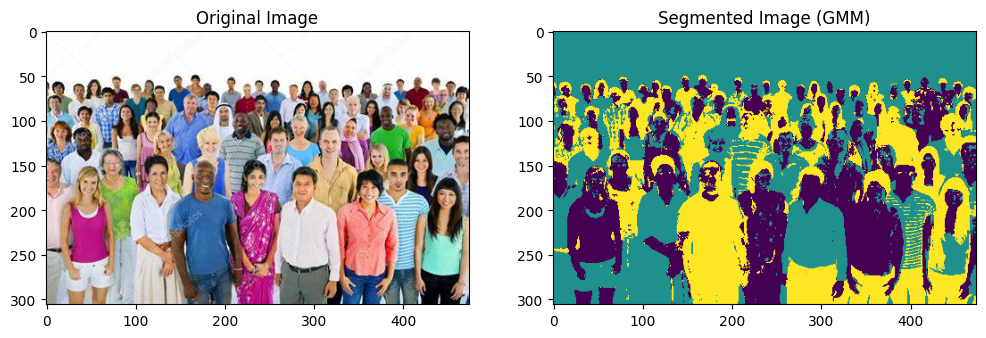

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Load and preprocess the image
img = cv2.imread('/content/drive/MyDrive/faces.jpg')  # Load image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img_reshaped = img.reshape((-1, 3))  # Flatten image to 2D (N, 3)

# Apply Gaussian Mixture Model (GMM)
n_components = 3  # Number of clusters (segments)
gmm = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=42)
gmm.fit(img_reshaped)

# Predict pixel labels and reshape to image
segmented_img = gmm.predict(img_reshaped)
segmented_img = segmented_img.reshape(img.shape[:2])

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(segmented_img, cmap="viridis")
ax[1].set_title("Segmented Image (GMM)")
plt.show()


# Gaussian Mixture Model Computation
(Step By Step Implementation)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


In [ ]:
X = np.array([
    [50, 80, 90],
    [120, 150, 170],
    [200, 220, 250]
], dtype=np.float64)

# Flatten the matrix for computation
X_flat = X.flatten()


In [ ]:
# Gaussian 1 (Lower Intensity Pixels)
mu1, sigma1 = 80, np.sqrt(500)   # Mean and standard deviation
pi1 = 0.6   # Mixture weight

# Gaussian 2 (Higher Intensity Pixels)
mu2, sigma2 = 200, np.sqrt(500)   # Mean and standard deviation
pi2 = 0.4   # Mixture weight


In [ ]:
# Compute probability density for Gaussian 1
P1 = norm.pdf(X_flat, mu1, sigma1)

# Compute probability density for Gaussian 2
P2 = norm.pdf(X_flat, mu2, sigma2)
print( P1,"\n\n",P2)

[7.25370735e-03 1.78412412e-02 1.61434226e-02 3.60208447e-03
 1.32856284e-04 5.41551496e-06 9.94453600e-09 5.48596735e-11
 5.01550349e-15] 

 [3.01855589e-12 9.94453600e-09 9.91886165e-08 2.96442440e-05
 1.46449826e-03 7.25370735e-03 1.78412412e-02 1.19593416e-02
 1.46449826e-03]


In [ ]:
# Compute responsibilities
gamma1 = (pi1 * P1) / ((pi1 * P1) + (pi2 * P2))
gamma2 = 1 - gamma1

print("gamma 1 \n",gamma1,"\n")
print("gamma 2 \n",gamma2)

gamma 1 
 [1.00000000e+00 9.99999628e-01 9.99995904e-01 9.94543439e-01
 1.19777919e-01 1.11862599e-03 8.36084855e-07 6.88077257e-09
 5.13708719e-12] 

gamma 2 
 [2.77426415e-10 3.71593441e-07 4.09612479e-06 5.45656062e-03
 8.80222081e-01 9.98881374e-01 9.99999164e-01 9.99999993e-01
 1.00000000e+00]


In [ ]:

gamma1_matrix = gamma1.reshape(3, 3)
gamma2_matrix = gamma2.reshape(3, 3)
print("gamma 1 matrix\n",gamma1_matrix,"\n")
print("gamma 2 matrix\n",gamma2_matrix)


gamma 1 matrix
 [[1.00000000e+00 9.99999628e-01 9.99995904e-01]
 [9.94543439e-01 1.19777919e-01 1.11862599e-03]
 [8.36084855e-07 6.88077257e-09 5.13708719e-12]] 

gamma 2 matrix
 [[2.77426415e-10 3.71593441e-07 4.09612479e-06]
 [5.45656062e-03 8.80222081e-01 9.98881374e-01]
 [9.99999164e-01 9.99999993e-01 1.00000000e+00]]


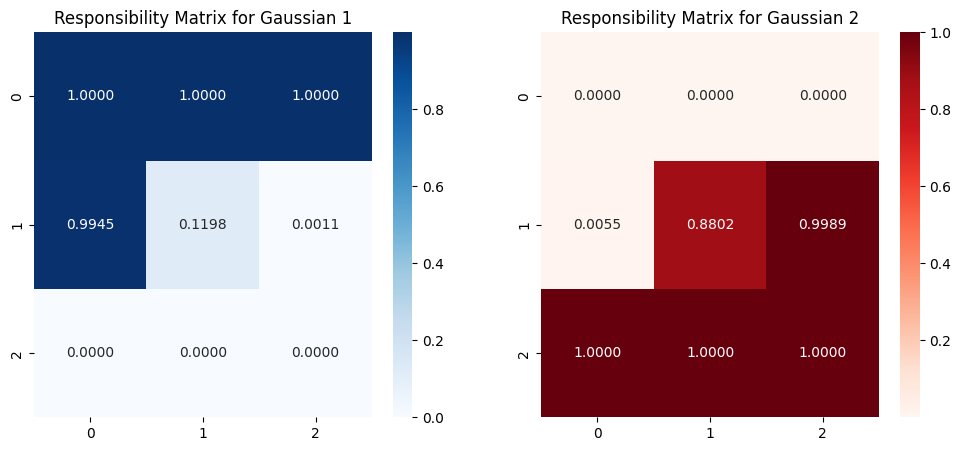

In [ ]:
plt.figure(figsize=(12, 5))

# Plot for Gaussian 1 Responsibilities
plt.subplot(1, 2, 1)
sns.heatmap(gamma1_matrix, annot=True, cmap="Blues", fmt=".4f")
plt.title("Responsibility Matrix for Gaussian 1")

# Plot for Gaussian 2 Responsibilities
plt.subplot(1, 2, 2)
sns.heatmap(gamma2_matrix, annot=True, cmap="Reds", fmt=".4f")
plt.title("Responsibility Matrix for Gaussian 2")

plt.show()


Expected Output: Heatmaps

Responsibility Matrix for Gaussian 1 (Blues):

* Higher values → More likely to belong to dark region.
* Lower values → More likely to belong to bright region.

Responsibility Matrix for Gaussian 2 (Reds):

* Higher values → More likely to belong to bright region.
* Lower values → More likely to belong to dark region.

Interpretation:
  * Low-intensity pixels (50, 80, 90) belong more to Gaussian 1.
  * High-intensity pixels (200, 220, 250) belong to Gaussian 2.
  * Middle values (120, 150, 170) have mixed responsibilities.

# Pose Estimation

###Pose Estimation using OpenPose (Pre-trained)